# Testing lal generate polarizations at a lower level.

Objectives:
1. Test lal raw modes load.
2. Test lal resampled waveform modes.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows:

1. [Step 1](#initialize): Initialize the environment.
1. [Step 2](#source): Setup the source.
1. [Step 3](#nrcat_modes): Load modes from nrcat.
1. [Step 4](#wftools_modes): Load modes from wftools.
1. [Step 5](#lal_write_modes): Write lal modes to disk.
1. [Step 6](#compare_lal_raw_modes): Compare raw lal modes with nrcat and wftools.
1. [Step 7](#compare_res_lal_modes): Compare resampled lal modes.
1. [Step 8](#convergence_test): Test the convergence of the resampled $\ell, m$ mode.

<a id='initialize'></a>

# Step 1: Initialize needed Python modules [Back to [top](#toc)\]
$$\label{initialize}$$

## Display the environment

In [1]:
%%bash
python --version
conda info --envs | grep '*'

Python 3.10.11
nrcat                 *  /home/vaishakprasad/soft/anaconda3/envs/nrcat


## Basic imports

In [2]:
import sys
import numpy as np
import h5py
from functools import partial

from pathlib import Path

home = str(Path.home())

### Ensure hdf5 write access

In [3]:
%%bash
export HDF5_USE_FILE_LOCKING=FALSE

## nrcatalogtools imports

In [4]:
# libpath = "/home/vaishakp/Codes/custom_libraries/nr-catalog-tools-vp/"
# libpath = '/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/nr-catalog-tools'
libpath = "/home/vaishakprasad/Documents/Codes/nr-catalog-tools-vp"
# libpath = '/home/vprasad/Documents/Projects/nr-catalog-tools-vp'
# lalpath = '/home/vaishakprasad/soft/lalsuite-dev/lib/python3.11/site-packages'
# lalpath = '/home/vaishakprasad/soft/lalsuite-dev/lib/python3.11/site-packages'

if libpath not in sys.path:
    sys.path.append(libpath)

# if lalpath not in sys.path:
#    sys.path = [lalpath] + sys.path

print(sys.path)
import nrcatalogtools

print(nrcatalogtools.__file__)

# import nrcatalogtools.lvc as lalutils
# from nrcatalogtools import utils
# from nrcatalogtools.lvc import get_lal_mode_dictionary_from_lmax
from nrcatalogtools.maya import MayaCatalog
from nrcatalogtools.utils import maya_catalog_info

['/home/vaishakprasad/Documents/Codes/nrcattools-local/test/notebooks', '', '/home/vaishakprasad/soft/lalsuite-dev/lib/python3.11/site-packages', '/home/vaishakprasad/Documents/Codes/config', '/home/vaishakprasad/Documents/Codes/waveformtools', '/home/vaishakprasad/Documents/Codes/qlmtools', '/home/vaishakprasad/Documents/Codes/nrcattools-local/test/notebooks', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python310.zip', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/lib-dynload', '/home/vaishakprasad/soft/anaconda3/envs/nrcat/lib/python3.10/site-packages', '/home/vaishakprasad/Documents/Codes/nr-catalog-tools-vp']
No version information file '.version' found
/home/vaishakprasad/Documents/Codes/nr-catalog-tools-vp/nrcatalogtools/__init__.py


### Apply lal convention to nrcat waveforms

In [5]:
nrcat_use_lal_conven = True

## Ensure lal paths

In [6]:
%%bash 
# Note: please run this before starting jupyter in bash
export LAL_DATA_PATH="/home/vaishakp/Softwares/lalsuite-extra/data/lalsimulation"

In [7]:
%%bash
echo $LAL_DATA_PATH

/home/vaishakprasad/soft/lalsuite/lalsuite-extra/data/lalsimulation


In [8]:
import lal

print(lal.__file__)

/home/vaishakprasad/soft/lalsuite-dev/lib/python3.11/site-packages/lal/__init__.py


### Ensure SEOBNRv4_ROM

In [9]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are available
# print(td_approximants())

apx = "SEOBNRv4_ROM"
if apx not in td_approximants():
    # print('Apx not loaded correctly!')
    raise AttributeError(f"Approximant {apx} not found! Please check `LAL_DATA_PATH`")
# List of fd approximants that are currently available
# print(fd_approximants())

### Set lal phi_ref brhavior

In [10]:
lal_use_coa_phase_as_phi_ref = False

## pycbc imports

In [11]:
from pycbc import pnutils
from pycbc.filter.matchedfilter import match
from pycbc.types.timeseries import TimeSeries
from pycbc.waveform.utils import coalign_waveforms

## Waveformtools imports

In [12]:
from waveformtools.waveforms import modes_array
from waveformtools.waveformtools import roll, xtract_camp_phase, match_wfs

/home/vaishakprasad/Documents/Codes/waveformtools/waveformtools


## Plotting

In [51]:
import matplotlib.pyplot as plt


#####################
# matplotlib presets
#########################################

labelsize = 16
labelpad = 14

plt.rcParams.update({"font.size": 12})
plt.rcParams.update({"figure.figsize": (8, 6)})
plt.rcParams.update({"axes.grid": True})
plt.rcParams.update({"axes.labelpad": labelpad})
plt.rcParams.update({"axes.labelsize": labelsize})
plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"grid.alpha": 0.3})
plt.rcParams.update({"grid.alpha": 0.3})
plt.rcParams.update({"legend.markerscale": 12})

<a id='source'></a>

# Step 2: Simulation selection [Back to [top](#toc)\]
$$\label{source}$$


In [14]:
sim_name = "GT0001"

# Parameters
M = 40
D = 1000
inc = np.pi / 3
# np.pi/3 - 0.0001
coa_phase = np.pi / 6
# coa_phase0 = np.pi/6
delta_t = 1.0 / (4 * 2048)

<a id='nrcat_modes'></a>

# Step 3 : Load the modes through nr-catalog-tools [Back to [top](#toc)\]
$$\label{nrcat_modes}$$

### MAYA cat details

In [15]:
nrcatalogtools.utils.maya_catalog_info

{'cache_dir': PosixPath('/home/vaishakprasad/.cache/MAYA'),
 'url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files',
 'metadata_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/catalog-table.txt',
 'data_dir': PosixPath('/home/vaishakprasad/.cache/MAYA/data'),
 'metadata_dir': PosixPath('/home/vaishakprasad/.cache/MAYA/metadata'),
 'data_url': 'https://raw.githubusercontent.com/cevans216/gt-waveform-catalog/master/h5files'}

## Load waveform

In [16]:
# sc = sxs.Catalog.load(download=True)
# rc = RITCatalog.load(verbosity=5, download=True)
mc = MayaCatalog.load(verbosity=1, download=False)

mwf1 = mc.get(sim_name)

In [17]:
phi_ref_obs = mwf1.get_obs_phi_ref_from_obs_coa_phase(coa_phase)

Computing reference time..
Reference time not found in waveform h5 file.
Reference time not found in simulation metadata file.
Reference time should be computed fromthe reference orbital frequency!
Reference orbital phase not found in simulation metadata.Proceeding to retrieve from the h5 file.. 'Omega'
No interpolation required.


<a id='wftools_modes'></a>
# Stwp 4: Generate waveform through waveformtools [Back to [top](#toc)\]




Waveforms are loaded using three interpolation methods:
1. 3rd order
2. 4th order
3. 5th order

$$\label{wftools_modes}$$

## Load the waveforms using different interpolation methods using waveformtools.

In [18]:
# Path to modes data
# fdir = "/home/vprasad/.cache/MAYA/data/"
fdir = str(maya_catalog_info["data_dir"])
fname = f"{sim_name}.h5"

In [19]:
resam_type = 0.01

In [20]:
# Default 3rd order interp1d
wfm3 = modes_array(label="GT1 3", data_dir=fdir, file_name=fname)
# 4th order InterpolatedUnivariateSpline
wfm4 = modes_array(label="GT1 4", data_dir=fdir, file_name=fname)
# 5th order
wfm5 = modes_array(label="GT1 5", data_dir=fdir, file_name=fname)

In [21]:
wfm3.load_modes(
    ftype="GT", var_type="Strain", resam_type=resam_type, interp_kind="cubic"
)

Passing /home/vaishakprasad/.cache/MAYA/data GT0001.h5
Loading RIT strain data.
Interpolating using interp1d
Fetching all keys from H5 file
['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'amp_l3_m-1', 'amp_l3_m-2', 'amp_l3_m-3', 'amp_l3_m0', 'amp_l3_m1', 'amp_l3_m2', 'amp_l3_m3', 'amp_l4_m-1', 'amp_l4_m-2', 'amp_l4_m-3', 'amp_l4_m-4', 'amp_l4_m0', 'amp_l4_m1', 'amp_l4_m2', 'amp_l4_m3', 'amp_l4_m4', 'amp_l5_m-1', 'amp_l5_m-2', 'amp_l5_m-3', 'amp_l5_m-4', 'amp_l5_m-5', 'amp_l5_m0', 'amp_l5_m1', 'amp_l5_m2', 'amp_l5_m3', 'amp_l5_m4', 'amp_l5_m5', 'amp_l6_m-1', 'amp_l6_m-2', 'amp_l6_m-3', 'amp_l6_m-4', 'amp_l6_m-5', 'amp_l6_m-6', 'amp_l6_m0', 'amp_l6_m1', 'amp_l6_m2', 'amp_l6_m3', 'amp_l6_m4', 'amp_l6_m5', 'amp_l6_m6', 'auxiliary-info', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2', 'phase_l3_m-1', 'phase_l3_m-2', 'phase_l3_m-3', 'phase_l3_m0', 'phase_l3_m1', 'phase_l3_m2', 'phase_l3_m3', 'phase_l4_m-1', 'phase_l4_m-2', 'phase_l4_m-3', 'ph

/home/vaishakprasad/Documents/Codes/waveformtools/waveformtools/dataIO.py:685: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  dt_auto = mode(np.diff(time_axis))[0][0]


Loading 2 -1
Loading 2 0
Loading 2 1
Loading 2 2
Loading 3 -3
Loading 3 -2
Loading 3 -1
Loading 3 0
Loading 3 1
Loading 3 2
Loading 3 3
Loading 4 -4
Loading 4 -3
Loading 4 -2
Loading 4 -1
Loading 4 0
Loading 4 1
Loading 4 2
Loading 4 3
Loading 4 4
Loading 5 -5
Loading 5 -4
Loading 5 -3
Loading 5 -2
Loading 5 -1
Loading 5 0
Loading 5 1
Loading 5 2
Loading 5 3
Loading 5 4
Loading 5 5
Loading 6 -6
Loading 6 -5
Loading 6 -4
Loading 6 -3
Loading 6 -2
Loading 6 -1
Loading 6 0
Loading 6 1
Loading 6 2
Loading 6 3
Loading 6 4
Loading 6 5
Loading 6 6


1

In [22]:
wfm4.load_modes(ftype="GT", var_type="Strain", resam_type=resam_type, interp_kind=4)

Passing /home/vaishakprasad/.cache/MAYA/data GT0001.h5
Loading RIT strain data.
Interpolating using InterpolatedUnivariateSpline
Fetching all keys from H5 file
['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'amp_l3_m-1', 'amp_l3_m-2', 'amp_l3_m-3', 'amp_l3_m0', 'amp_l3_m1', 'amp_l3_m2', 'amp_l3_m3', 'amp_l4_m-1', 'amp_l4_m-2', 'amp_l4_m-3', 'amp_l4_m-4', 'amp_l4_m0', 'amp_l4_m1', 'amp_l4_m2', 'amp_l4_m3', 'amp_l4_m4', 'amp_l5_m-1', 'amp_l5_m-2', 'amp_l5_m-3', 'amp_l5_m-4', 'amp_l5_m-5', 'amp_l5_m0', 'amp_l5_m1', 'amp_l5_m2', 'amp_l5_m3', 'amp_l5_m4', 'amp_l5_m5', 'amp_l6_m-1', 'amp_l6_m-2', 'amp_l6_m-3', 'amp_l6_m-4', 'amp_l6_m-5', 'amp_l6_m-6', 'amp_l6_m0', 'amp_l6_m1', 'amp_l6_m2', 'amp_l6_m3', 'amp_l6_m4', 'amp_l6_m5', 'amp_l6_m6', 'auxiliary-info', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2', 'phase_l3_m-1', 'phase_l3_m-2', 'phase_l3_m-3', 'phase_l3_m0', 'phase_l3_m1', 'phase_l3_m2', 'phase_l3_m3', 'phase_l4_m-1', 'phase_l4_m-2',

1

In [23]:
wfm5.load_modes(ftype="GT", var_type="Strain", resam_type=resam_type, interp_kind=5)

Passing /home/vaishakprasad/.cache/MAYA/data GT0001.h5
Loading RIT strain data.
Interpolating using InterpolatedUnivariateSpline
Fetching all keys from H5 file
['amp_l2_m-1', 'amp_l2_m-2', 'amp_l2_m0', 'amp_l2_m1', 'amp_l2_m2', 'amp_l3_m-1', 'amp_l3_m-2', 'amp_l3_m-3', 'amp_l3_m0', 'amp_l3_m1', 'amp_l3_m2', 'amp_l3_m3', 'amp_l4_m-1', 'amp_l4_m-2', 'amp_l4_m-3', 'amp_l4_m-4', 'amp_l4_m0', 'amp_l4_m1', 'amp_l4_m2', 'amp_l4_m3', 'amp_l4_m4', 'amp_l5_m-1', 'amp_l5_m-2', 'amp_l5_m-3', 'amp_l5_m-4', 'amp_l5_m-5', 'amp_l5_m0', 'amp_l5_m1', 'amp_l5_m2', 'amp_l5_m3', 'amp_l5_m4', 'amp_l5_m5', 'amp_l6_m-1', 'amp_l6_m-2', 'amp_l6_m-3', 'amp_l6_m-4', 'amp_l6_m-5', 'amp_l6_m-6', 'amp_l6_m0', 'amp_l6_m1', 'amp_l6_m2', 'amp_l6_m3', 'amp_l6_m4', 'amp_l6_m5', 'amp_l6_m6', 'auxiliary-info', 'phase_l2_m-1', 'phase_l2_m-2', 'phase_l2_m0', 'phase_l2_m1', 'phase_l2_m2', 'phase_l3_m-1', 'phase_l3_m-2', 'phase_l3_m-3', 'phase_l3_m0', 'phase_l3_m1', 'phase_l3_m2', 'phase_l3_m3', 'phase_l4_m-1', 'phase_l4_m-2',

1

In [24]:
wfm3.get_metadata()

{'label': 'GT1 3',
 'data_dir': '/home/vaishakprasad/.cache/MAYA/data',
 'file_name': 'GT0001.h5',
 'key_format': None,
 'ell_max': 6,
 'modes_list': [[2, [-2, -1, 0, 1, 2]],
  [3, [-3, -2, -1, 0, 1, 2, 3]],
  [4, [-4, -3, -2, -1, 0, 1, 2, 3, 4]],
  [5, [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]],
  [6, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]]],
 'r_ext': 500,
 'frequency_axis': None,
 'out_file_name': None,
 'maxtime': None,
 'date': '2023-05-14',
 'time': '13:55:19',
 'key_ex': None,
 'spin_weight': -2}

In [25]:
wfm3.delta_t()

0.010000000000005116

<a id='lal_write_modes'></a>
# Step 5 : Write the LAL modes to disk. [Back to [top](#toc)\]

Using [a modified version of the script.](https://github.com/cevans216/gt-waveform-catalog/tree/master/scripts)

$$\label{lal_write_modes}$$

Here, `coa_phase` is missing from h5 file's attributes. Correcting for this and loading the same simulation as in the catalogue load, 

In [26]:
if lal_use_coa_phase_as_phi_ref is False:
    lal_coa_phase = phi_ref_obs

['Contact Person', 'Format', 'INSPIRE-bibtex-keys', 'LNhatx', 'LNhaty', 'LNhatz', 'Lmax', 'NR-code', 'NR-group', 'NR-techniques', 'Omega', 'PN_approximant', 'Warning1', 'alternative-names', 'comparable-simulation', 'eccentricity', 'eta', 'f_lower_at_1MSUN', 'f_lower_at_1MSUN ', 'files-in-error-series', 'horizon_mass1', 'horizon_mass2', 'init_sep', 'license', 'mean_anomaly', 'modification-date', 'name', 'nhatx', 'nhaty', 'nhatz', 'number_of_orbits', 'object1', 'object2', 'point-of-contact-email', 'production-run', 'puncture_mass1', 'puncture_mass2', 'simulation-type', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'type']
Cannot find the attribute `coa_phase` in the file. Setting to 0.5235987755982988
Loading waveform
inclination 1.047198, phi ref 2.949683, fref -40.000000
Writing to /home/vaishakprasad/Modes_data.dat

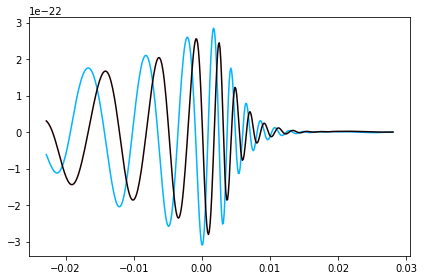

In [27]:
# Waveform path
fdir = maya_catalog_info["cache_dir"]
file = f"{fdir}/data/{sim_name}.h5"

# Add sim info to LAL data intercept file
with open(home + "/Modes_data.dat", "w") as mfile:
    mfile.write(f"### {sim_name}\n")

with open(home + "/raw_hlm.dat", "w") as mfile:
    mfile.write(f"### {sim_name}\n")


try:
    f.close()
except:
    pass

f = h5py.File(file, "a")

# Extrinsic parameters:
f_lower = 1
f_lower_at_1MSUN = f_lower / M
if "f_lower_at_1MSUN" not in list(f.attrs.keys()):
    f.attrs["f_lower_at_1MSUN"] = f_lower_at_1MSUN
    f.close()
else:
    f.close()

f = h5py.File(file, "r")
print(list(f.attrs.keys()))
# print(f.attrs.keys())
# print(f.keys())
params = {}


params["f_lower"] = f_lower
params["mtotal"] = M  # 150.0
params["inclination"] = inc  # 0.0
params["distance"] = D  # 100.0

# Metadata parameters:

params["eta"] = f.attrs["eta"]

params["mass1"] = pnutils.mtotal_eta_to_mass1_mass2(params["mtotal"], params["eta"])[0]
params["mass2"] = pnutils.mtotal_eta_to_mass1_mass2(params["mtotal"], params["eta"])[1]

# BH1 spins
params["spin1x"] = f.attrs["spin1x"]
params["spin1y"] = f.attrs["spin1y"]
params["spin1z"] = f.attrs["spin1z"]


# BH2 spins

params["spin2x"] = f.attrs["spin2x"]
params["spin2y"] = f.attrs["spin2y"]
params["spin2z"] = f.attrs["spin2z"]


# Spin unit vectors

params["nhat"] = [f.attrs["nhatx"], f.attrs["nhaty"], f.attrs["nhatz"]]
params["lnhat"] = [f.attrs["LNhatx"], f.attrs["LNhaty"], f.attrs["LNhatz"]]


# Check for coa_phase, else use the phase from nr cat load.
try:
    params["coa_phase"] = f.attrs["coa_phase"]
    raise Exception["NR coa phase is present!"]
except:
    print(f"Cannot find the attribute `coa_phase` in the file. Setting to {coa_phase}")
    # raise AttributeError('Cannot find the attribute `coa_phase` in the file')
    params["coa_phase"] = lal_coa_phase

# Transform spins

# NR frame
s1 = [params["spin1x"], params["spin1y"], params["spin1z"]]
s2 = [params["spin2x"], params["spin2y"], params["spin2z"]]

# LAL frame
from nrcatalogtools.lvc import transform_spins_nr_to_lal

S1, S2 = transform_spins_nr_to_lal(s1, s2, params["nhat"], params["lnhat"])

from pycbc.waveform import get_td_waveform


print("Loading waveform")
hp_l, hx_l = get_td_waveform(
    approximant="NR_hdf5",
    numrel_data=file,
    mass1=params["mass1"],
    mass2=params["mass2"],
    spin1x=S1[0],
    spin1y=S1[1],
    spin1z=S1[2],
    spin2x=S2[0],
    spin2y=S2[1],
    spin2z=S2[2],
    delta_t=delta_t,
    f_lower=f_lower,
    inclination=params["inclination"],
    coa_phase=params["coa_phase"],
    distance=params["distance"],
)

#
time_l = np.array(range(len(hp_l))) * delta_t
mtime = time_l[np.argmax(hp_l**2 + hx_l**2)]
time_l -= mtime
# pyplot.figure()
plt.plot(time_l, hp_l, color=[0, 0.7071, 1])
plt.plot(time_l, hx_l, color=[0.1, 0, 0])
plt.show()
f.close()

<a id='compare_lal_raw_modes'></a>
# Step 6: Load and test the lal raw $\ell, m$ modes. [Back to [top](#toc)\]

$$\label{compare_lal_raw_modes}$$

## Select the mode

In [28]:
ell = 2
emm = 2

## Load the modes directly from disk

In [29]:
with h5py.File(str(fdir) + "/data/" + fname) as f:
    pdata_X = np.array(f[f"phase_l{ell}_m{emm}"]["X"])
    pdata_Y = np.array(f[f"phase_l{ell}_m{emm}"]["Y"])

    adata_X = np.array(f[f"amp_l{ell}_m{emm}"]["X"])
    adata_Y = np.array(f[f"amp_l{ell}_m{emm}"]["Y"])

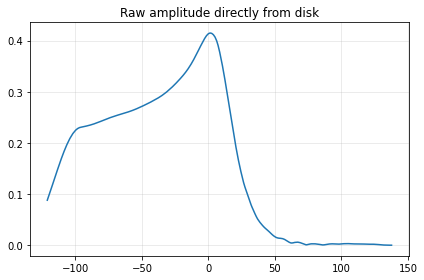

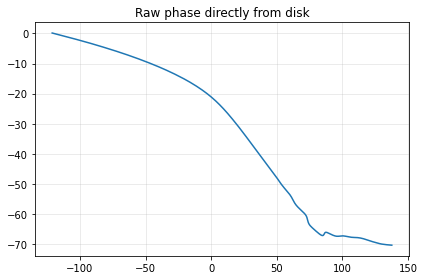

In [30]:
plt.plot(adata_X, adata_Y)
plt.title("Raw amplitude directly from disk")
plt.grid()
plt.show()

plt.plot(pdata_X, pdata_Y)
plt.title("Raw phase directly from disk")
plt.grid()
plt.show()

## Load the intercepted lal raw modes

In [31]:
raw_mdata = np.genfromtxt("/home/vaishakprasad/raw_hlm.dat", dtype=None)

<ipython-input-31-51dd1d0d502b>:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  raw_mdata = np.genfromtxt('/home/vaishakprasad/raw_hlm.dat', dtype=None)


## Load from LAL intercept and compare with direct load.

In [32]:
errs_amp = []
errs_phase = []

plot = False

for ell in range(2, 7):
    for emm in range(-ell, ell + 1):
        # for ell in range(2, 7):
        #    for emm in range(-ell, ell+1):
        n2 = raw_mdata.shape[0]

        taxis_amp = []
        taxis_phase = []
        mode_amp_lm = []
        mode_phase_lm = []

        for index in range(n2):
            key, X, Y = raw_mdata[index]
            key = str(key)
            # print(X)
            # print(key)
            if f"l{ell}" in key and f"m{emm}" in key:
                # print(key)
                if "amp" in key:
                    taxis_amp.append(X)
                    mode_amp_lm.append(Y)
                elif "phase" in key:
                    taxis_phase.append(X)
                    mode_phase_lm.append(Y)

        mode_amp_lm = np.array(mode_amp_lm)
        mode_phase_lm = np.array(mode_phase_lm)

        with h5py.File(str(fdir) + "/data/" + fname) as f:
            pdata_X = np.array(f[f"phase_l{ell}_m{emm}"]["X"])
            pdata_Y = np.array(f[f"phase_l{ell}_m{emm}"]["Y"])

            adata_X = np.array(f[f"amp_l{ell}_m{emm}"]["X"])
            adata_Y = np.array(f[f"amp_l{ell}_m{emm}"]["Y"])

        damp = mode_amp_lm - adata_Y
        dphase = mode_phase_lm - pdata_Y

        errs_amp.append(np.amax(np.absolute(damp)))
        errs_phase.append(np.amax(np.absolute(dphase)))

    if plot is True:
        plt.plot(damp)
        plt.title(f"Amp l{ell} m{emm}")
        plt.show()

        plt.plot(dphase)
        plt.title(f"Phase l{ell} m{emm}")
        plt.show()

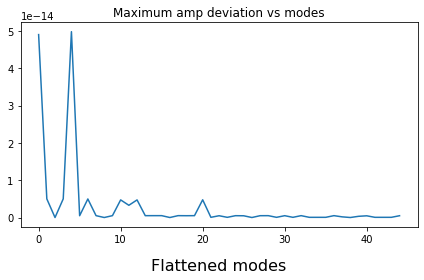

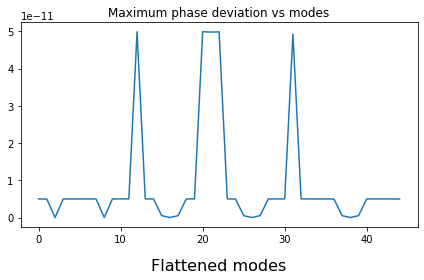

In [33]:
plt.plot(errs_amp)
plt.title("Maximum amp deviation vs modes")
plt.xlabel("Flattened modes")
plt.show()

plt.plot(errs_phase)
plt.title("Maximum phase deviation vs modes")
plt.xlabel("Flattened modes")
plt.show()

<a id='compare_res_lal_modes'></a>
# Step 7: Load and test the lal resampled $\ell, m$ mode. [Back to [top](#toc)\]

$$\label{compare_res_lal_modes}$$

In [34]:
resamp_mdata = np.genfromtxt("/home/vaishakprasad/Modes_data.dat")

## Deviations from actual direct load

0.0


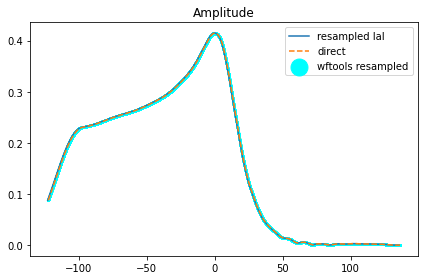

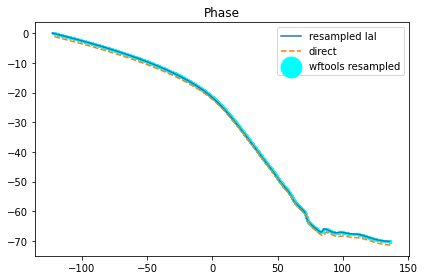

Max index locations: nrcat, wftools, direct, lal
198 198 198 198
After rolling
Max index locations: nrcat, wftools, direct, lal
198 198 198 198


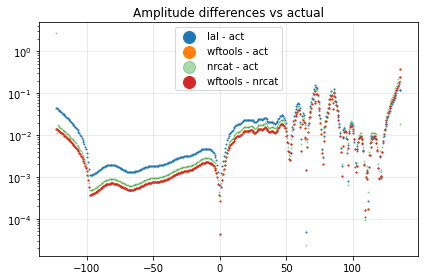

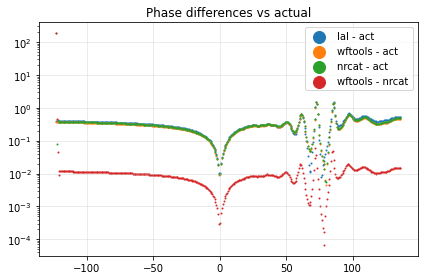

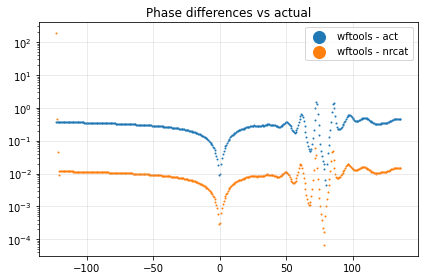

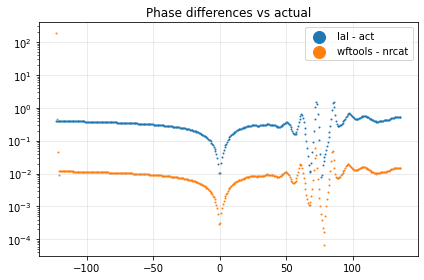

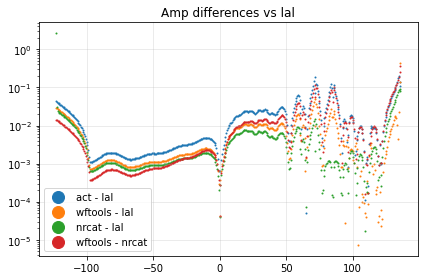

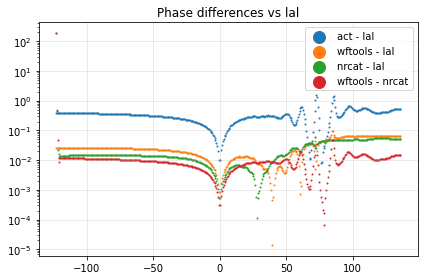

In [35]:
errs_amp = []
errs_phase = []

# Set the order of waveformtools interpolation modes
# to be compared against.

wfm = wfm5

mwf = mwf1

# kind='linear'
kind = 5


mean_lb = int(2 * wfm.data_len / 5)
mean_ub = int(4 * wfm.data_len / 5)

subtract_mean_phase = False
equalize_coa_phase = True
ell = 2
emm = 2

for ell in [ell]:
    for emm in [emm]:
        # for ell in range(2, 7):
        #    for emm in range(-ell, ell+1):

        ##################
        # Waveformtools
        ##################

        # Recenter
        wfm.trim(trim_upto_time=0)
        # wftools time axis
        time_wftools = wfm.time_axis
        # wftools is already centered.
        # Recenter nrcat modes
        mtime = time_wftools[np.argmax(np.absolute(wfm.mode(ell, emm)))]
        print(mtime)
        time_wftools -= mtime

        amp_wftools = roll(np.absolute(wfm.mode(ell, emm)), 0)
        phase_wftools = roll(np.unwrap(np.angle(wfm.mode(ell, emm))), 0)

        ######################
        # NRcat modes
        ######################
        wf_nrcat = mwf.get_mode(ell, emm)[:, 1] + 1j * mwf.get_mode(ell, emm)[:, 2]
        time_nrcat = mwf.time
        amp_nrcat = roll(np.absolute(wf_nrcat), 0)
        phase_nrcat = roll(np.unwrap(np.angle(wf_nrcat)), 0)

        amp_nrcat = roll(amp_nrcat, 1)
        phase_nrcat = roll(phase_nrcat, 1)

        # Recenter nrcat modes
        mtime = time_nrcat[np.argmax(amp_nrcat)]
        time_nrcat -= mtime

        ########################
        # LAL resampled modes
        ########################
        # number of data rows
        n2 = raw_mdata.shape[0]

        mode_lal_rs = []
        amp_lal = []
        phase_lal = []

        time_lal_rs = []
        time_ind_lal_unsorted = resamp_mdata[:, 0]
        # time_ind_lal_unsorted = list(set(resamp_mdata[:, 0]))

        # print('Len', len(time_lal_unsorted))

        for index in range(len(time_ind_lal_unsorted)):
            # print(index)
            tindex, ell_val, emm_val, Yslm_re, Yslm_im, Clm_re, Clm_im = resamp_mdata[
                index, :
            ]

            ell_val = int(ell_val)
            emm_val = int(emm_val)
            # print(ell, ell_val, emm, emm_val)
            # print(X)
            # print(key)
            if (ell_val == ell) and (emm_val == emm):
                # print('Found at', tindex)
                Clm = Clm_re + 1j * Clm_im

                time_lal_rs.append(tindex * delta_t)
                mode_lal_rs.append(Clm)

        amp_lal_rs = np.absolute(mode_lal_rs)
        phase_lal_rs = np.unwrap(np.angle(mode_lal_rs))

        # Recenter lal resampled modes
        mtime_lal = time_lal_rs[np.argmax(amp_lal_rs)]
        time_lal_rs -= mtime_lal

        duration_lal = max(time_lal_rs) - min(time_lal_rs)

        # Rescale lal amp axis

        ##############################################
        # Load raw modes from disk for comparison
        ##############################################

        with h5py.File(str(fdir) + "/data/" + fname) as f:
            pdata_X = np.array(f[f"phase_l{ell}_m{emm}"]["X"])
            pdata_Y = np.array(f[f"phase_l{ell}_m{emm}"]["Y"])

            adata_X = np.array(f[f"amp_l{ell}_m{emm}"]["X"])
            adata_Y = np.array(f[f"amp_l{ell}_m{emm}"]["Y"])

        # damp = amp_lal_rs - adata_Y
        # dphase = phase_lal_rs - pdata_Y
        ########################################
        # Recenter directly loaded modes
        mtime = adata_X[np.argmax(adata_Y)]
        adata_X -= mtime
        pdata_Y -= mtime

        amax_lal = np.amax(amp_lal_rs)
        amax_act = np.amax(adata_Y)
        amp_rat = amax_lal / amax_act

        amp_lal_rs /= amp_rat

        duration_disk_amp = max(adata_X) - min(adata_X)
        duration_disk_phase = max(pdata_X) - min(pdata_X)

        if duration_disk_amp != duration_disk_phase:
            raise ValueError(
                f"The durations Amp{duration_disk_amp} and Phase{duration_disk_phase} are unequal"
                f"\n Difference is {duration_disk_amp - duration_disk_phase}"
            )
        ####################################################
        tratio = duration_lal / duration_disk_amp

        # Reset the time axis duration of lal
        time_lal_rs /= tratio
        ########################################################

        errs_amp.append(np.amax(np.absolute(damp)))
        errs_phase.append(np.amax(np.absolute(dphase)))

        # plt.plot(damp)
        # plt.title(f'Amp l{ell} m{emm}')
        # plt.show()

        # plt.plot(dphase)
        # plt.title(f'Phase l{ell} m{emm}')
        # plt.show()

        plt.plot(time_lal_rs, amp_lal_rs, label="resampled lal")
        plt.plot(adata_X, adata_Y, label="direct", linestyle="--")
        plt.scatter(time_wftools, amp_wftools, label="wftools resampled", s=2, c="cyan")
        plt.title("Amplitude")
        plt.legend()
        # plt.plot()
        plt.show()

        # plt.scatter(taxis_amp, mode_amp_lm, label='resampled lal', s=1)
        # plt.scatter(adata_X, adata_Y, label='raw lal', linestyle='--', s=1)
        # plt.plot()
        # plt.show()

        plt.plot(time_lal_rs, phase_lal_rs, label="resampled lal")
        plt.plot(pdata_X, pdata_Y, label="direct", linestyle="--")
        plt.scatter(
            time_wftools, phase_wftools, label="wftools resampled", s=3, c="cyan"
        )
        plt.title("Phase")
        plt.legend()
        # plt.plot()
        plt.show()

        if isinstance(kind, int):
            from scipy.interpolate import InterpolatedUnivariateSpline as interpol

            interpolator = partial(interpol, k=kind)

        if isinstance(kind, str):
            from scipy.interpolate import interp1d as interpol

            interpolator = partial(interpol, kind=kind)

        ############################
        # Common time axis
        ############################

        tmin = max(time_nrcat[0], time_wftools[0], adata_X[0], pdata_X[0])
        tmax = min(time_nrcat[-1], time_wftools[-1], adata_X[-1], pdata_X[-1])

        # ctaxis = np.linspace(tmin, tmax, wfm.data_len)
        ctaxis = time_lal_rs
        #########################
        # resample
        #########################

        # time_wftools +=0.9
        # adata_Y_rs = interp1d(adata_X, adata_Y, kind='cubic')(ctaxis)
        # mode_amp_lm_rs = interp1d(taxis_amp, mode_amp_lm, kind='cubic')(ctaxis)
        # amp_wftools_rs = interp1d(time_wftools, amp_wftools, kind='cubic')(ctaxis)
        # amp_nrcat_rs = interp1d(time_nrcat, amp_nrcat, kind='cubic')(ctaxis)

        # pdata_Y_rs = interp1d(pdata_X, pdata_Y, kind='cubic')(ctaxis)
        # mode_phase_lm_rs = interp1d(taxis_phase, mode_phase_lm, kind='cubic')(ctaxis)
        # phase_wftools_rs = interp1d(time_wftools, phase_wftools, kind='cubic')(ctaxis)
        # phase_nrcat_rs = interp1d(time_nrcat, phase_nrcat, kind='cubic')(ctaxis)

        amp_act_rs = interpolator(adata_X, adata_Y)(ctaxis)
        # amp_lm_rs = interpolator(taxis_amp, mode_amp_lm)(ctaxis)
        amp_wftools_rs = interpolator(time_wftools, amp_wftools)(ctaxis)
        amp_nrcat_rs = interpolator(time_nrcat, amp_nrcat)(ctaxis)

        phase_act_rs = interpolator(pdata_X, pdata_Y)(ctaxis)
        # mode_phase_lm_rs = interpolator(taxis_phase, mode_phase_lm)(ctaxis)
        phase_wftools_rs = interpolator(time_wftools, phase_wftools)(ctaxis)
        phase_nrcat_rs = interpolator(time_nrcat, phase_nrcat)(ctaxis)

        ############################
        # Roll axis if needed
        ############################

        imax_n, imax_w, imax_a, imax_l = (
            np.argmax(amp_nrcat_rs),
            np.argmax(amp_wftools_rs),
            np.argmax(amp_act_rs),
            np.argmax(amp_lal_rs),
        )
        print("Max index locations: nrcat, wftools, direct, lal")
        print(imax_n, imax_w, imax_a, imax_l)

        s_na = imax_n - imax_a
        s_wa = imax_w - imax_a

        amp_wftools_rs = roll(amp_wftools_rs, -s_wa)
        phase_wftools_rs = roll(phase_wftools_rs, -s_wa)

        amp_nrcat_rs = roll(amp_nrcat_rs, -s_na)
        phase_nrcat_rs = roll(phase_nrcat_rs, -s_na)

        print("After rolling")
        imax_n, imax_w, imax_a, imax_l = (
            np.argmax(amp_nrcat_rs),
            np.argmax(amp_wftools_rs),
            np.argmax(amp_act_rs),
            np.argmax(amp_lal_rs),
        )
        print("Max index locations: nrcat, wftools, direct, lal")
        print(imax_n, imax_w, imax_a, imax_l)

        ##########################
        # Equalize coa phases
        ##########################
        cp_n = phase_nrcat_rs[imax_n]
        cp_a = phase_act_rs[imax_a]
        cp_w = phase_wftools_rs[imax_w]
        cp_l = phase_lal_rs[imax_l]

        if equalize_coa_phase is True:
            phase_nrcat_rs -= cp_n
            phase_lal_rs -= cp_l
            phase_wftools_rs -= cp_w
            phase_act_rs -= cp_a

        ##########################
        # Compare
        ##########################

        # vs direct interpolate
        damp_na = amp_nrcat_rs / amp_act_rs - 1
        damp_la = amp_lal_rs / amp_act_rs - 1
        damp_wa = amp_wftools_rs / amp_act_rs - 1
        damp_wn = amp_wftools_rs / amp_act_rs - 1

        dphase_na = phase_nrcat_rs - phase_act_rs
        dphase_la = phase_lal_rs - phase_act_rs
        dphase_wa = phase_wftools_rs - phase_act_rs

        dphase_wn = phase_wftools_rs - phase_nrcat_rs

        # vs lal
        damp_nl = amp_nrcat_rs / amp_lal_rs - 1
        damp_al = amp_act_rs / amp_lal_rs - 1
        damp_wl = amp_wftools_rs / amp_lal_rs - 1

        dphase_nl = phase_nrcat_rs - phase_lal_rs
        dphase_al = phase_act_rs - phase_lal_rs
        dphase_wl = phase_wftools_rs - phase_lal_rs

        if subtract_mean_phase is True:
            dphase_na -= np.mean(dphase_na[mean_lb:mean_ub])
            dphase_la -= np.mean(dphase_la[mean_lb:mean_ub])
            dphase_wa -= np.mean(dphase_wa[mean_lb:mean_ub])
            dphase_wn -= np.mean(dphase_wn[mean_lb:mean_ub])

            dphase_nl -= np.mean(dphase_nl[mean_lb:mean_ub])
            dphase_al -= np.mean(dphase_al[mean_lb:mean_ub])
            dphase_wl -= np.mean(dphase_wl[mean_lb:mean_ub])

        fig, ax = plt.subplots()
        ax.set_yscale("log")

        ax.scatter(ctaxis, np.absolute(damp_la), label="lal - act", s=1)
        ax.scatter(ctaxis, np.absolute(damp_wa), label="wftools - act", s=1)
        ax.scatter(ctaxis, np.absolute(damp_na), label="nrcat - act", s=1, alpha=0.4)
        ax.scatter(ctaxis, np.absolute(damp_wn), label="wftools - nrcat", s=1)
        plt.title("Amplitude differences vs actual")
        plt.grid()
        plt.legend()
        plt.show()

        fig, ax = plt.subplots()
        ax.set_yscale("log")
        ax.scatter(ctaxis, np.absolute(dphase_la), label="lal - act", s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wa), label="wftools - act", s=1)
        ax.scatter(ctaxis, np.absolute(dphase_na), label="nrcat - act", s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wn), label="wftools - nrcat", s=1)
        plt.title("Phase differences vs actual")
        plt.grid()
        plt.legend()
        plt.show()

        fig, ax = plt.subplots()
        ax.set_yscale("log")
        # ax.scatter(ctaxis, np.absolute(dphase_la), label='lal - act', s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wa), label="wftools - act", s=1)
        # ax.scatter(ctaxis, np.absolute(dphase_na), label='nrcat - act', s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wn), label="wftools - nrcat", s=1)
        plt.title("Phase differences vs actual")
        plt.grid()
        plt.legend()
        plt.show()

        fig, ax = plt.subplots()
        ax.set_yscale("log")
        ax.scatter(ctaxis, np.absolute(dphase_la), label="lal - act", s=1)
        # ax.scatter(ctaxis, np.absolute(dphase_wa), label='wftools - act', s=1)
        # ax.scatter(ctaxis, np.absolute(dphase_na), label='nrcat - act', s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wn), label="wftools - nrcat", s=1)
        plt.title("Phase differences vs actual")
        plt.grid()
        plt.legend()
        plt.show()

        fig, ax = plt.subplots()
        ax.set_yscale("log")

        ax.scatter(ctaxis, np.absolute(damp_al), label="act - lal", s=1)
        ax.scatter(ctaxis, np.absolute(damp_wl), label="wftools - lal", s=1)
        ax.scatter(ctaxis, np.absolute(damp_nl), label="nrcat - lal", s=1)
        ax.scatter(ctaxis, np.absolute(damp_wn), label="wftools - nrcat", s=1)
        plt.title("Amp differences vs lal")
        plt.grid()
        plt.legend()
        plt.show()

        fig, ax = plt.subplots()
        ax.set_yscale("log")
        ax.scatter(ctaxis, np.absolute(dphase_al), label="act - lal", s=1)
        # ax.scatter(ctaxis, np.absolute(dphase_la), label='lal-act', s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wl), label="wftools - lal", s=1)
        ax.scatter(ctaxis, np.absolute(dphase_nl), label="nrcat - lal", s=1)
        ax.scatter(ctaxis, np.absolute(dphase_wn), label="wftools - nrcat", s=1)
        plt.title("Phase differences vs lal")
        plt.grid()
        plt.legend()
        plt.show()

        #################################
        # Compute matches
        #################################

<a id='convergence_test'></a>
# Step 8: Test the convergence of resampling of $\ell, m$ mode. [Back to [top](#toc)\]

Here, we test the convergence by computing the matches of nrcat, wftools and lal resampled mode data against directly loaded and resampled mode data.

1. Here, waveformtools is loading modes at different resampling orders (3, 4, 5) of InterpolatedUnivariateSpline.
2. Direct loading can resample at given order (3, 4, 5) using InterpolatedUnivariateSpline.
3. nrcat is loading through CubicSpline
4. lal is loading through gsl_cspline

$$\label{convergence_test}$$



0.0
0.0
0.0


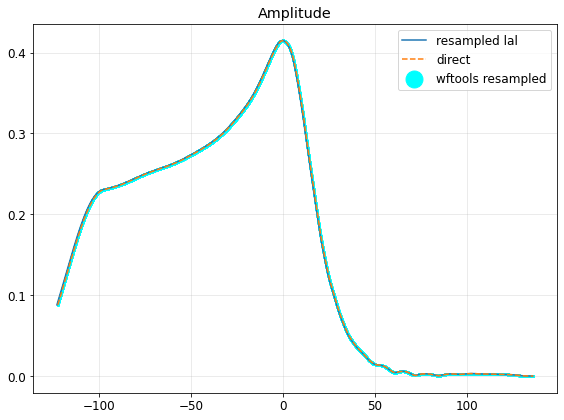

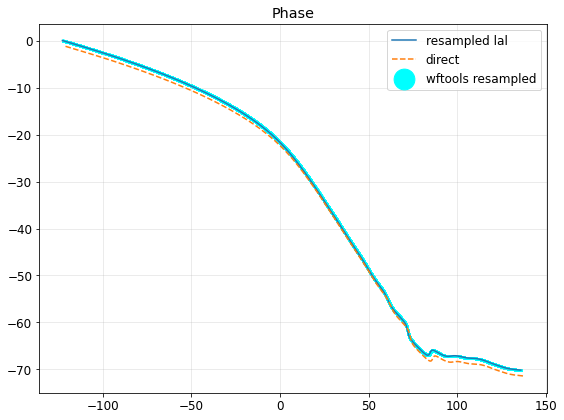

Max index locations: nrcat, wftools, direct, lal
198 198 198 198 198 198
These ^ should be the same!


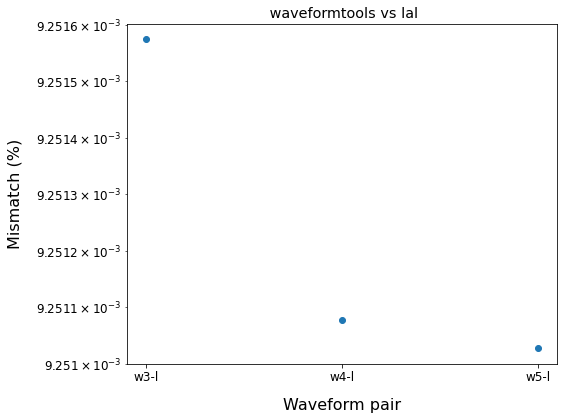

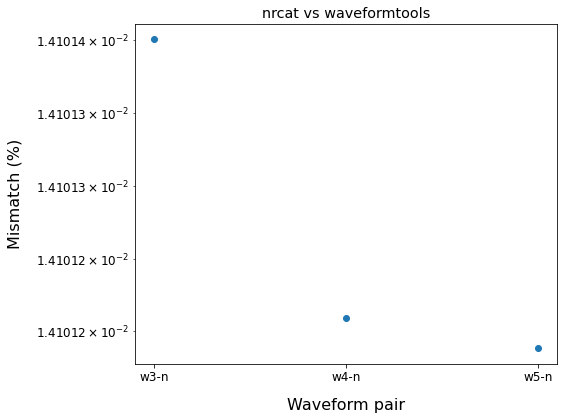

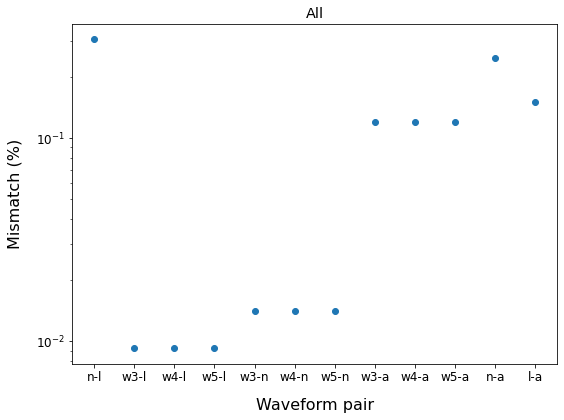

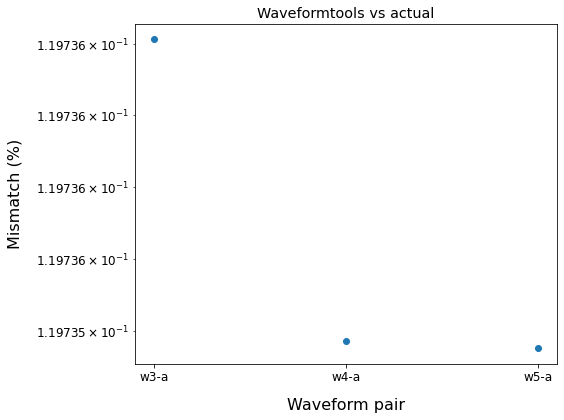

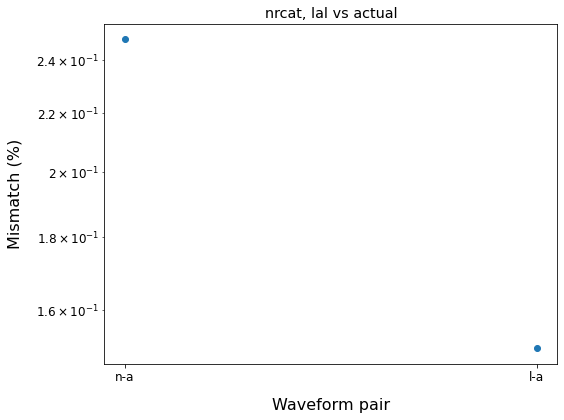

In [53]:
# Not used
errs_amp = []
errs_phase = []

# Set the order of waveformtools interpolation modes
# to be compared against.
# The maya waveform modes
mwf = mwf1


# Interpolation order for comparisons
# Use kind='linear', 'q'
# kind='linear'
kind = 3

# Interpolation order for base
# reference waveform (direct load)
kind0 = 5

mean_lb = int(2 * wfm.data_len / 5)
mean_ub = int(4 * wfm.data_len / 5)

subtract_mean_phase = False
equalize_coa_phase = True
ell = 2
emm = 2

for ell in [ell]:
    for emm in [emm]:
        # for ell in range(2, 7):
        #    for emm in range(-ell, ell+1):

        ##################
        # Waveformtools
        ##################

        # Third order interpolation
        # Recenter
        wfm3.trim(trim_upto_time=0)
        # wftools time axis
        time_wftools_3 = wfm3.time_axis
        # wftools is already centered.
        # Recenter nrcat modes
        mtime = time_wftools_3[np.argmax(np.absolute(wfm3.mode(ell, emm)))]
        print(mtime)
        time_wftools_3 -= mtime
        amp_wftools_3 = np.absolute(wfm.mode(ell, emm))
        phase_wftools_3 = np.unwrap(np.angle(wfm3.mode(ell, emm)))

        # Fourth order interpolation
        # Recenter
        wfm4.trim(trim_upto_time=0)
        # wftools time axis
        time_wftools_4 = wfm4.time_axis
        # wftools is already centered.
        # Recenter nrcat modes
        mtime = time_wftools_4[np.argmax(np.absolute(wfm4.mode(ell, emm)))]
        print(mtime)
        time_wftools_4 -= mtime
        amp_wftools_4 = np.absolute(wfm.mode(ell, emm))
        phase_wftools_4 = np.unwrap(np.angle(wfm4.mode(ell, emm)))

        # Fifth order interpolation
        # Recenter
        wfm5.trim(trim_upto_time=0)
        # wftools time axis
        time_wftools_5 = wfm5.time_axis
        # wftools is already centered.
        # Recenter nrcat modes
        mtime = time_wftools_5[np.argmax(np.absolute(wfm5.mode(ell, emm)))]
        print(mtime)
        time_wftools_5 -= mtime
        amp_wftools_5 = np.absolute(wfm.mode(ell, emm))
        phase_wftools_5 = np.unwrap(np.angle(wfm5.mode(ell, emm)))

        ######################
        # NRcat modes
        ######################
        wf_nrcat = mwf.get_mode(ell, emm)[:, 1] + 1j * mwf.get_mode(ell, emm)[:, 2]
        time_nrcat = mwf.time
        amp_nrcat = roll(np.absolute(wf_nrcat), 0)
        phase_nrcat = roll(np.unwrap(np.angle(wf_nrcat)), 0)

        amp_nrcat = roll(amp_nrcat, 1)
        phase_nrcat = roll(phase_nrcat, 1)

        # Recenter nrcat modes
        mtime = time_nrcat[np.argmax(amp_nrcat)]
        time_nrcat -= mtime

        ########################
        # LAL resampled modes
        ########################
        # number of data rows
        n2 = raw_mdata.shape[0]

        mode_lal_rs = []
        amp_lal = []
        phase_lal = []

        time_lal_rs = []
        time_ind_lal_unsorted = resamp_mdata[:, 0]
        # time_ind_lal_unsorted = list(set(resamp_mdata[:, 0]))

        # print('Len', len(time_lal_unsorted))

        for index in range(len(time_ind_lal_unsorted)):
            # print(index)
            tindex, ell_val, emm_val, Yslm_re, Yslm_im, Clm_re, Clm_im = resamp_mdata[
                index, :
            ]

            ell_val = int(ell_val)
            emm_val = int(emm_val)
            # print(ell, ell_val, emm, emm_val)
            # print(X)
            # print(key)
            if (ell_val == ell) and (emm_val == emm):
                # print('Found at', tindex)
                Clm = Clm_re + 1j * Clm_im

                time_lal_rs.append(tindex * delta_t)
                mode_lal_rs.append(Clm)

        amp_lal_rs = np.absolute(mode_lal_rs)
        phase_lal_rs = np.unwrap(np.angle(mode_lal_rs))

        # Recenter lal resampled modes
        mtime_lal = time_lal_rs[np.argmax(amp_lal_rs)]
        time_lal_rs -= mtime_lal

        duration_lal = max(time_lal_rs) - min(time_lal_rs)

        # Rescale lal amp axis

        ##############################################
        # Load raw modes from disk for comparison
        ##############################################

        with h5py.File(str(fdir) + "/data/" + fname) as f:
            pdata_X = np.array(f[f"phase_l{ell}_m{emm}"]["X"])
            pdata_Y = np.array(f[f"phase_l{ell}_m{emm}"]["Y"])

            adata_X = np.array(f[f"amp_l{ell}_m{emm}"]["X"])
            adata_Y = np.array(f[f"amp_l{ell}_m{emm}"]["Y"])

        # damp = amp_lal_rs - adata_Y
        # dphase = phase_lal_rs - pdata_Y
        ########################################
        # Recenter directly loaded modes
        mtime = adata_X[np.argmax(adata_Y)]
        adata_X -= mtime
        pdata_Y -= mtime

        amax_lal = np.amax(amp_lal_rs)
        amax_act = np.amax(adata_Y)
        amp_rat = amax_lal / amax_act

        amp_lal_rs /= amp_rat

        duration_disk_amp = max(adata_X) - min(adata_X)
        duration_disk_phase = max(pdata_X) - min(pdata_X)

        if duration_disk_amp != duration_disk_phase:
            raise ValueError(
                f"The durations Amp{duration_disk_amp} and Phase{duration_disk_phase} are unequal"
                f"\n Difference is {duration_disk_amp - duration_disk_phase}"
            )
        ####################################################
        tratio = duration_lal / duration_disk_amp

        # Reset the time axis duration of lal
        time_lal_rs /= tratio
        ########################################################

        errs_amp.append(np.amax(np.absolute(damp)))
        errs_phase.append(np.amax(np.absolute(dphase)))

        # plt.plot(damp)
        # plt.title(f'Amp l{ell} m{emm}')
        # plt.show()

        # plt.plot(dphase)
        # plt.title(f'Phase l{ell} m{emm}')
        # plt.show()

        plt.plot(time_lal_rs, amp_lal_rs, label="resampled lal")
        plt.plot(adata_X, adata_Y, label="direct", linestyle="--")
        plt.scatter(time_wftools, amp_wftools, label="wftools resampled", s=2, c="cyan")
        plt.title("Amplitude")
        plt.legend()
        # plt.plot()
        plt.show()

        # plt.scatter(taxis_amp, mode_amp_lm, label='resampled lal', s=1)
        # plt.scatter(adata_X, adata_Y, label='raw lal', linestyle='--', s=1)
        # plt.plot()
        # plt.show()

        plt.plot(time_lal_rs, phase_lal_rs, label="resampled lal")
        plt.plot(pdata_X, pdata_Y, label="direct", linestyle="--")
        plt.scatter(
            time_wftools, phase_wftools, label="wftools resampled", s=3, c="cyan"
        )
        plt.title("Phase")
        plt.legend()
        # plt.plot()
        plt.show()

        if isinstance(kind, int):
            from scipy.interpolate import InterpolatedUnivariateSpline as interpol

            # For all but direct
            interpolator = partial(interpol, k=kind)

        if isinstance(kind, str):
            from scipy.interpolate import interp1d as interpol

            interpolator = partial(interpol, kind=kind)

        if isinstance(kind0, int):
            from scipy.interpolate import InterpolatedUnivariateSpline as interpol

            # For direct only
            interpolator0 = partial(interpol, k=kind0)

        if isinstance(kind0, str):
            from scipy.interpolate import interp1d as interpol

            # For direct only
            interpolator0 = partial(interpol, kind=kind0)

        ############################
        # Common time axis
        ############################

        tmin = max(time_nrcat[0], time_wftools[0], adata_X[0], pdata_X[0])
        tmax = min(time_nrcat[-1], time_wftools[-1], adata_X[-1], pdata_X[-1])

        # ctaxis = np.linspace(tmin, tmax, wfm.data_len)
        ctaxis = time_lal_rs
        #########################
        # resample
        #########################

        # time_wftools +=0.9
        # adata_Y_rs = interp1d(adata_X, adata_Y, kind='cubic')(ctaxis)
        # mode_amp_lm_rs = interp1d(taxis_amp, mode_amp_lm, kind='cubic')(ctaxis)
        # amp_wftools_rs = interp1d(time_wftools, amp_wftools, kind='cubic')(ctaxis)
        # amp_nrcat_rs = interp1d(time_nrcat, amp_nrcat, kind='cubic')(ctaxis)

        # pdata_Y_rs = interp1d(pdata_X, pdata_Y, kind='cubic')(ctaxis)
        # mode_phase_lm_rs = interp1d(taxis_phase, mode_phase_lm, kind='cubic')(ctaxis)
        # phase_wftools_rs = interp1d(time_wftools, phase_wftools, kind='cubic')(ctaxis)
        # phase_nrcat_rs = interp1d(time_nrcat, phase_nrcat, kind='cubic')(ctaxis)

        amp_act_rs = interpolator0(adata_X, adata_Y)(ctaxis)
        # amp_lm_rs = interpolator(taxis_amp, mode_amp_lm)(ctaxis)
        amp_w3_rs = interpolator(time_wftools_3, amp_wftools_3)(ctaxis)
        amp_w4_rs = interpolator(time_wftools_4, amp_wftools_4)(ctaxis)
        amp_w5_rs = interpolator(time_wftools_5, amp_wftools_5)(ctaxis)

        amp_nrcat_rs = interpolator(time_nrcat, amp_nrcat)(ctaxis)

        phase_act_rs = interpolator0(pdata_X, pdata_Y)(ctaxis)
        # mode_phase_lm_rs = interpolator(taxis_phase, mode_phase_lm)(ctaxis)
        phase_w3_rs = interpolator(time_wftools_3, phase_wftools_3)(ctaxis)
        phase_w4_rs = interpolator(time_wftools_4, phase_wftools_4)(ctaxis)
        phase_w5_rs = interpolator(time_wftools_5, phase_wftools_5)(ctaxis)

        phase_nrcat_rs = interpolator(time_nrcat, phase_nrcat)(ctaxis)

        ############################
        # Roll axis if needed
        ############################

        imax_n, imax_w3, imax_w4, imax_w5, imax_imax_a, imax_l = (
            np.argmax(amp_nrcat_rs),
            np.argmax(amp_w3_rs),
            np.argmax(amp_w4_rs),
            np.argmax(amp_w5_rs),
            np.argmax(amp_act_rs),
            np.argmax(amp_lal_rs),
        )
        print("Max index locations: nrcat, wftools, direct, lal")
        print(imax_n, imax_w3, imax_w4, imax_w5, imax_a, imax_l)
        print("These ^ should be the same!")
        # s_na = imax_n-imax_a
        # s_wa = imax_w - imax_a

        # amp_wftools_rs = roll(amp_wftools_rs, -s_wa)
        # phase_wftools_rs = roll(phase_wftools_rs, -s_wa)

        # amp_nrcat_rs = roll(amp_nrcat_rs, -s_na)
        # phase_nrcat_rs = roll(phase_nrcat_rs, -s_na)

        # print('After rolling')
        # imax_n, imax_w3, imax_w4, imax_w5, imax_imax_a, imax_l = np.argmax(amp_nrcat_rs), np.argmax(amp_w3_rs), np.argmax(amp_w4_rs), np.argmax(amp_w5_rs), np.argmax(amp_act_rs), np.argmax(amp_lal_rs)
        # print('Max index locations: nrcat, wftools, direct, lal')
        # print(imax_n, imax_w3, imax_w4, imax_w5, imax_a, imax_l)

        ##########################
        # Equalize coa phases
        ##########################
        cp_n = phase_nrcat_rs[imax_n]
        cp_a = phase_act_rs[imax_a]
        cp_w3 = phase_w3_rs[imax_w3]
        cp_w4 = phase_w4_rs[imax_w4]
        cp_w5 = phase_w5_rs[imax_w5]
        cp_l = phase_lal_rs[imax_l]

        if equalize_coa_phase is True:
            phase_nrcat_rs -= cp_n
            phase_lal_rs -= cp_l
            phase_w3_rs -= cp_w3
            phase_w4_rs -= cp_w4
            phase_w5_rs -= cp_w5
            phase_act_rs -= cp_a

        ##########################
        # Compute mismatches
        ##########################

        hp_n = TimeSeries(amp_nrcat_rs * np.cos(phase_nrcat_rs), delta_t=delta_t)
        hx_n = TimeSeries(amp_nrcat_rs * np.sin(phase_nrcat_rs), delta_t=delta_t)

        hp_l = TimeSeries(amp_lal_rs * np.cos(phase_lal_rs), delta_t=delta_t)
        hx_l = TimeSeries(amp_lal_rs * np.cos(phase_lal_rs), delta_t=delta_t)

        hp_a = TimeSeries(amp_act_rs * np.cos(phase_act_rs), delta_t=delta_t)
        hx_a = TimeSeries(amp_act_rs * np.cos(phase_act_rs), delta_t=delta_t)

        hp_w3 = TimeSeries(amp_w3_rs * np.cos(phase_w3_rs), delta_t=delta_t)
        hx_w3 = TimeSeries(amp_w3_rs * np.cos(phase_w3_rs), delta_t=delta_t)

        hp_w4 = TimeSeries(amp_w4_rs * np.cos(phase_w4_rs), delta_t=delta_t)
        hx_w4 = TimeSeries(amp_w4_rs * np.cos(phase_w4_rs), delta_t=delta_t)

        hp_w5 = TimeSeries(amp_w5_rs * np.cos(phase_w5_rs), delta_t=delta_t)
        hx_w5 = TimeSeries(amp_w5_rs * np.cos(phase_w5_rs), delta_t=delta_t)

        # vs lal
        mp_nl = match(hp_n, hp_l)[0]
        mx_nl = match(hx_n, hx_l)[0]
        m_nl = min(mp_nl, mx_nl)
        mm_nl = 100 * (1 - m_nl)

        mp_w3l = match(hp_w3, hp_l)[0]
        mx_w3l = match(hx_w3, hx_l)[0]
        m_w3l = min(mp_w3l, mx_w3l)
        mm_w3l = 100 * (1 - m_w3l)

        mp_w4l = match(hp_w4, hp_l)[0]
        mx_w4l = match(hx_w4, hp_l)[0]
        m_w4l = min(mp_w4l, mx_w4l)
        mm_w4l = 100 * (1 - m_w4l)

        mp_w5l = match(hp_w5, hp_l)[0]
        mx_w5l = match(hx_w5, hp_l)[0]
        m_w5l = min(mp_w5l, mx_w5l)
        mm_w5l = 100 * (1 - m_w5l)

        # vs nrcat
        mp_w3n = match(hp_w3, hp_n)[0]
        mx_w3n = match(hx_w3, hp_n)[0]
        m_w3n = min(mp_w3n, mx_w3n)
        mm_w3n = 100 * (1 - m_w3n)

        mp_w4n = match(hp_w4, hp_n)[0]
        mx_w4n = match(hx_w4, hp_n)[0]
        m_w4n = min(mp_w4n, mx_w4n)
        mm_w4n = 100 * (1 - m_w4n)

        mp_w5n = match(hp_w5, hp_n)[0]
        mx_w5n = match(hx_w5, hp_n)[0]
        m_w5n = min(mp_w5n, mx_w5n)
        mm_w5n = 100 * (1 - m_w5n)

        # Vs actual
        # vs lal
        mp_na = match(hp_n, hp_a)[0]
        mx_na = match(hx_n, hx_a)[0]
        m_na = min(mp_na, mx_na)
        mm_na = 100 * (1 - m_na)

        # vs lal
        mp_la = match(hp_a, hp_l)[0]
        mx_la = match(hx_a, hx_l)[0]
        m_la = min(mp_la, mx_la)
        mm_la = 100 * (1 - m_la)

        mp_w3a = match(hp_w3, hp_a)[0]
        mx_w3a = match(hx_w3, hx_a)[0]
        m_w3a = min(mp_w3a, mx_w3a)
        mm_w3a = 100 * (1 - m_w3a)

        mp_w4a = match(hp_w4, hp_a)[0]
        mx_w4a = match(hx_w4, hp_a)[0]
        m_w4a = min(mp_w4a, mx_w4a)
        mm_w4a = 100 * (1 - m_w4a)

        mp_w5a = match(hp_w5, hp_a)[0]
        mx_w5a = match(hx_w5, hp_a)[0]
        m_w5a = min(mp_w5a, mx_w5a)
        mm_w5a = 100 * (1 - m_w5a)

        pol_mismatches = {
            "n-l": mm_nl,
            "w3-l": mm_w3l,
            "w4-l": mm_w4l,
            "w5-l": mm_w5l,
            "w3-n": mm_w3n,
            "w4-n": mm_w4n,
            "w5-n": mm_w5n,
            "w3-a": mm_w3a,
            "w4-a": mm_w4a,
            "w5-a": mm_w5a,
            "n-a": mm_na,
            "l-a": mm_la,
        }

        keys = ["w3-l", "w4-l", "w5-l"]
        vals = [pol_mismatches[key] for key in keys]
        fig, ax = plt.subplots()
        ax.set_yscale("log")
        ax.scatter(keys, vals)
        ax.set_xlabel("Waveform pair")
        ax.set_ylabel("Mismatch (%)")
        plt.title(" waveformtools vs lal")
        plt.grid()
        plt.show()

        keys = ["w3-n", "w4-n", "w5-n"]
        vals = [pol_mismatches[key] for key in keys]
        fig, ax = plt.subplots()
        plt.title("nrcat vs waveformtools")
        ax.set_yscale("log")
        ax.scatter(keys, vals)
        ax.set_xlabel("Waveform pair")
        ax.set_ylabel("Mismatch (%)")
        plt.grid()
        plt.show()

        fig, ax = plt.subplots()
        ax.set_yscale("log")
        ax.scatter(pol_mismatches.keys(), pol_mismatches.values())
        plt.title("All")
        ax.set_xlabel("Waveform pair")
        ax.set_ylabel("Mismatch (%)")
        plt.grid()
        plt.show()

        # vs act
        keys = ["w3-a", "w4-a", "w5-a"]
        vals = [pol_mismatches[key] for key in keys]
        fig, ax = plt.subplots()
        plt.title("Waveformtools vs actual")
        ax.set_yscale("log")
        ax.scatter(keys, vals)
        ax.set_xlabel("Waveform pair")
        ax.set_ylabel("Mismatch (%)")
        ax.grid()
        plt.show()

        # vs act
        keys = ["n-a", "l-a"]
        vals = [pol_mismatches[key] for key in keys]
        fig, ax = plt.subplots()
        plt.title("nrcat, lal vs actual")
        ax.set_yscale("log")
        ax.scatter(keys, vals)
        ax.set_xlabel("Waveform pair")
        ax.set_ylabel("Mismatch (%)")
        plt.grid()
        plt.show()